# S2Cool EDA

This notebook is EDA-only. It loads the processed feature matrix and generates diagnostic visualizations for data understanding and drift checks.

In [3]:
from pathlib import Path
import logging

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

logging.basicConfig(level=logging.INFO, format='%(asctime)s | %(levelname)s | %(message)s')

FEATURES_CSV_PATH = Path('../data/processed/s2cool_features_ready.csv')
VISUALIZATION_DIR = Path('visualizations')
SPLITS_DIR = Path('data/splits')
TARGET_COLUMNS = ['Target_GHI_next_1h', 'Target_Temp_next_1h']

VISUALIZATION_DIR.mkdir(parents=True, exist_ok=True)
SPLITS_DIR.mkdir(parents=True, exist_ok=True)

In [4]:
if not FEATURES_CSV_PATH.exists():
    raise FileNotFoundError(f'Processed feature file not found: {FEATURES_CSV_PATH}')

df = pd.read_csv(FEATURES_CSV_PATH)
if df.empty:
    raise ValueError('Processed feature CSV is empty.')

if 'Timestamp' not in df.columns:
    raise KeyError("Processed feature CSV must include a 'Timestamp' column.")

df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce', utc=True)
if df['Timestamp'].isna().any():
    raise ValueError('Failed to parse one or more Timestamp values from processed CSV.')

df = df.sort_values('Timestamp').reset_index(drop=True)
df.head()

,Timestamp,City,GHI,Ambient_Temp,day_of_year,hour_sin,hour_cos,month_sin,month_cos,GHI_lag_1,...,Ambient_Temp_lag_1,Ambient_Temp_lag_2,Ambient_Temp_lag_3,Ambient_Temp_lag_24,Ambient_Temp_lag_48,GHI_rolling_mean_3h,GHI_rolling_std_3h,Temp_rolling_mean_6h,Target_GHI_next_1h,Target_Temp_next_1h
0,2025-02-22 00:00:00+00:00,Islamabad,0.0,-1.659441,53,0.965926,2.588190e-01,0.866025,0.5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,10.7
1,2025-02-22 00:00:00+00:00,Karachi,0.0,-0.537541,53,0.965926,2.588190e-01,0.866025,0.5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,18.9
2,2025-02-22 00:00:00+00:00,Lahore,0.0,-1.486841,53,0.965926,2.588190e-01,0.866025,0.5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,13.2
3,2025-02-22 00:00:00+00:00,Peshawar,0.0,-1.881355,53,0.965926,2.588190e-01,0.866025,0.5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,8.8
4,2025-02-22 01:00:00+00:00,Karachi,0.0,-0.586856,53,1.000000,6.123234e-17,0.866025,0.5,-0.741132,...,-0.537535,NaN,NaN,NaN,NaN,-0.770299,NaN,-0.550725,0.0,18.5


## Part A — Automated EDA Visualizations

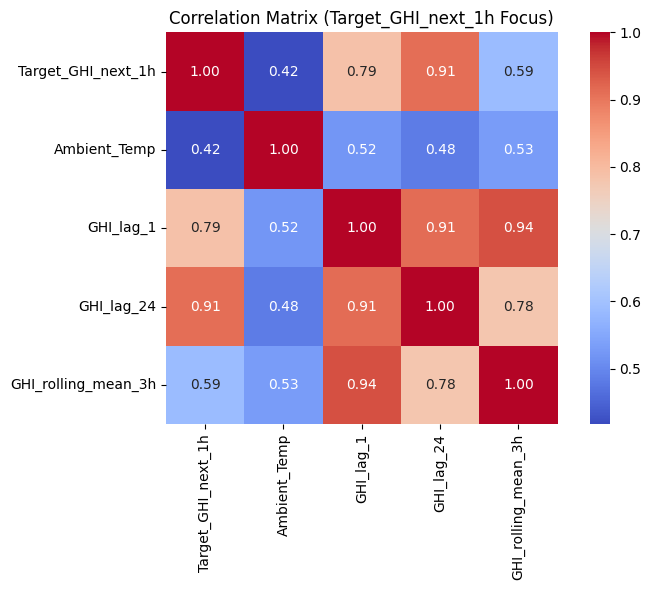

In [5]:
# 1) Correlation heatmap
corr_columns = [
    'Target_GHI_next_1h',
    'Ambient_Temp',
    'GHI_lag_1',
    'GHI_lag_24',
    'GHI_rolling_mean_3h',
]
missing = [c for c in corr_columns if c not in df.columns]
if missing:
    raise KeyError(f'Missing required columns for correlation heatmap: {missing}')

corr = df[corr_columns].corr(numeric_only=True)
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Correlation Matrix (Target_GHI_next_1h Focus)')
plt.tight_layout()
plt.savefig(VISUALIZATION_DIR / 'corr_heatmap.png', dpi=300)
plt.show()

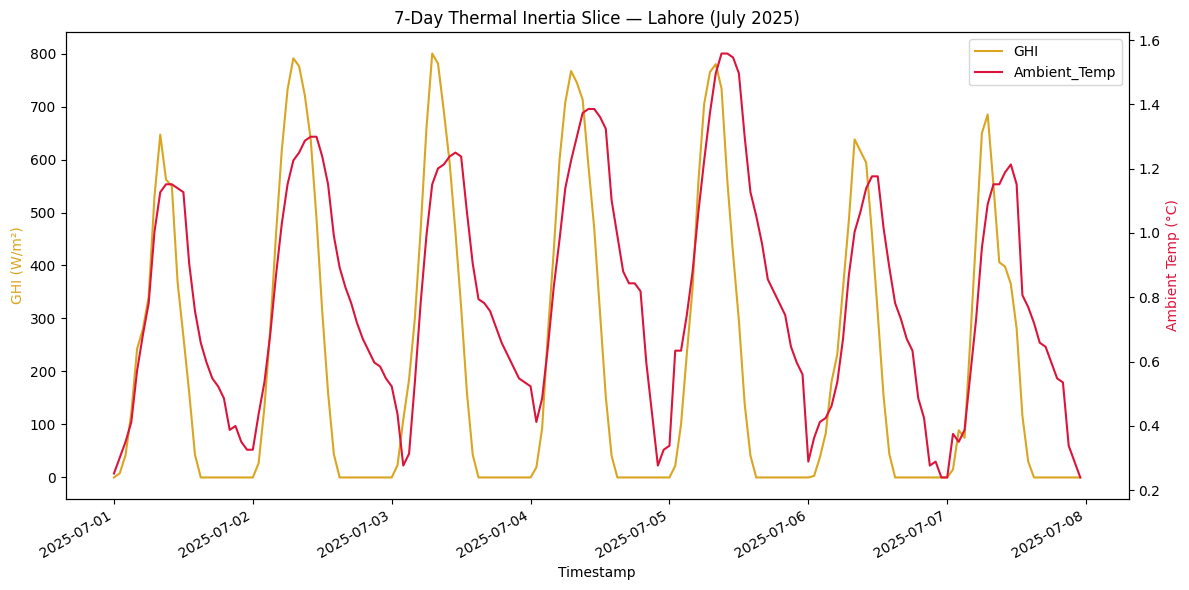

In [6]:
# 2) Thermal inertia 7-day slice (Lahore, July 1-7 2025)
required = ['City', 'Timestamp', 'GHI', 'Ambient_Temp']
missing = [c for c in required if c not in df.columns]
if missing:
    raise KeyError(f'Missing required columns for thermal inertia plot: {missing}')

start = pd.Timestamp('2025-07-01 00:00:00', tz='UTC')
end = pd.Timestamp('2025-07-07 23:00:00', tz='UTC')
city = 'Lahore'
slice_df = df[(df['City'] == city) & (df['Timestamp'] >= start) & (df['Timestamp'] <= end)].copy()
if slice_df.empty:
    raise ValueError(f'No rows available for city={city} in requested period.')

fig, ax_left = plt.subplots(figsize=(12, 6))
ax_right = ax_left.twinx()
ax_left.plot(slice_df['Timestamp'], slice_df['GHI'], color='goldenrod', label='GHI')
ax_right.plot(slice_df['Timestamp'], slice_df['Ambient_Temp'], color='crimson', label='Ambient_Temp')
ax_left.set_xlabel('Timestamp')
ax_left.set_ylabel('GHI (W/m²)', color='goldenrod')
ax_right.set_ylabel('Ambient Temp (°C)', color='crimson')
plt.title('7-Day Thermal Inertia Slice — Lahore (July 2025)')
left_lines, left_labels = ax_left.get_legend_handles_labels()
right_lines, right_labels = ax_right.get_legend_handles_labels()
ax_left.legend(left_lines + right_lines, left_labels + right_labels, loc='upper right')
fig.autofmt_xdate()
plt.tight_layout()
plt.savefig(VISUALIZATION_DIR / '7_day_thermal_slice.png', dpi=300)
plt.show()

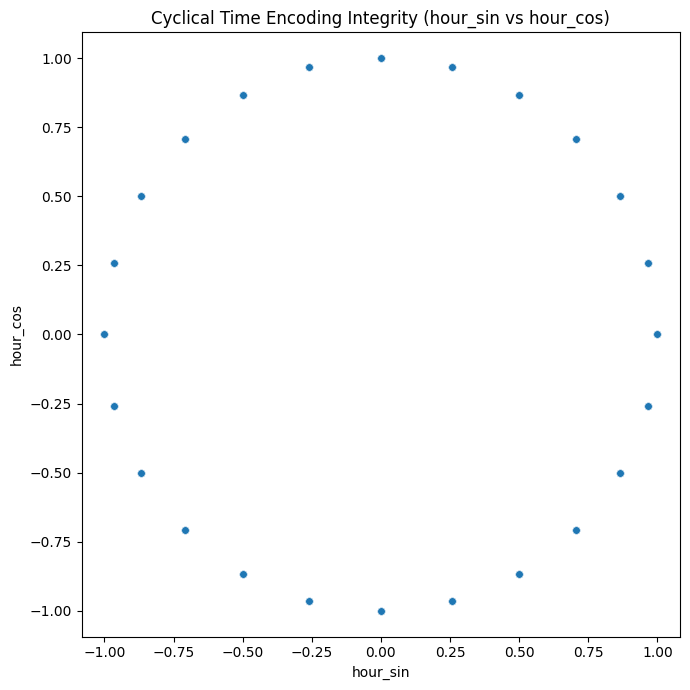

In [7]:
# 3) Cyclical integrity check
required = ['hour_sin', 'hour_cos']
missing = [c for c in required if c not in df.columns]
if missing:
    raise KeyError(f'Missing required columns for cyclical proof: {missing}')

plt.figure(figsize=(7, 7))
sns.scatterplot(x=df['hour_sin'], y=df['hour_cos'], s=30, alpha=0.65)
plt.title('Cyclical Time Encoding Integrity (hour_sin vs hour_cos)')
plt.xlabel('hour_sin')
plt.ylabel('hour_cos')
plt.axis('equal')
plt.tight_layout()
plt.savefig(VISUALIZATION_DIR / 'cyclical_time_proof.png', dpi=300)
plt.show()